In [1]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv('medium_posts.csv')
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [2]:
df['published_date'] = pd.to_datetime(df['published']).dt.date
df.head()

,published,domain,url,published_date
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...,2012-08-13
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...,2012-08-13
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...,2016-11-04
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...,2016-12-24
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...,2015-09-22


In [3]:
df_by_day = df['published_date'].value_counts().sort_index()
df_by_day

1970-01-01      2
1970-01-18      3
2003-09-14      1
2004-04-04      1
2004-04-16      1
             ... 
2017-06-23    421
2017-06-24    277
2017-06-25    253
2017-06-26    207
2017-06-27     36
Name: published_date, Length: 1738, dtype: int64

In [4]:
df_by_day = df_by_day.iloc[2:]
df_by_day.head()

2003-09-14    1
2004-04-04    1
2004-04-16    1
2005-09-12    1
2006-02-19    1
Name: published_date, dtype: int64

In [5]:
df_by_day = df_by_day.to_frame()
df_by_day['ds'] = df_by_day.index

In [6]:
df_by_day.rename(columns={"published_date":"y"}, inplace=True)

In [7]:
df_by_day.head()

,y,ds
2003-09-14,1,2003-09-14
2004-04-04,1,2004-04-04
2004-04-16,1,2004-04-16
2005-09-12,1,2005-09-12
2006-02-19,1,2006-02-19


In [8]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.FATAL)
m = Prophet()
m.add_seasonality(name='monthly', period=30.4, fourier_order=5)
m.fit(df_by_day)
future = m.make_future_dataframe(periods=365)
future.tail()

14:37:44 - cmdstanpy - INFO - Chain [1] start processing
14:37:44 - cmdstanpy - INFO - Chain [1] done processing


,ds
2096,2018-06-23
2097,2018-06-24
2098,2018-06-25
2099,2018-06-26
2100,2018-06-27


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2096,2018-06-23,424.738041,395.230873,454.299226
2097,2018-06-24,423.085558,391.361290,454.798479
2098,2018-06-25,445.840444,416.574464,478.447316
2099,2018-06-26,444.986217,415.351947,475.454346
2100,2018-06-27,446.618474,416.270833,477.655583


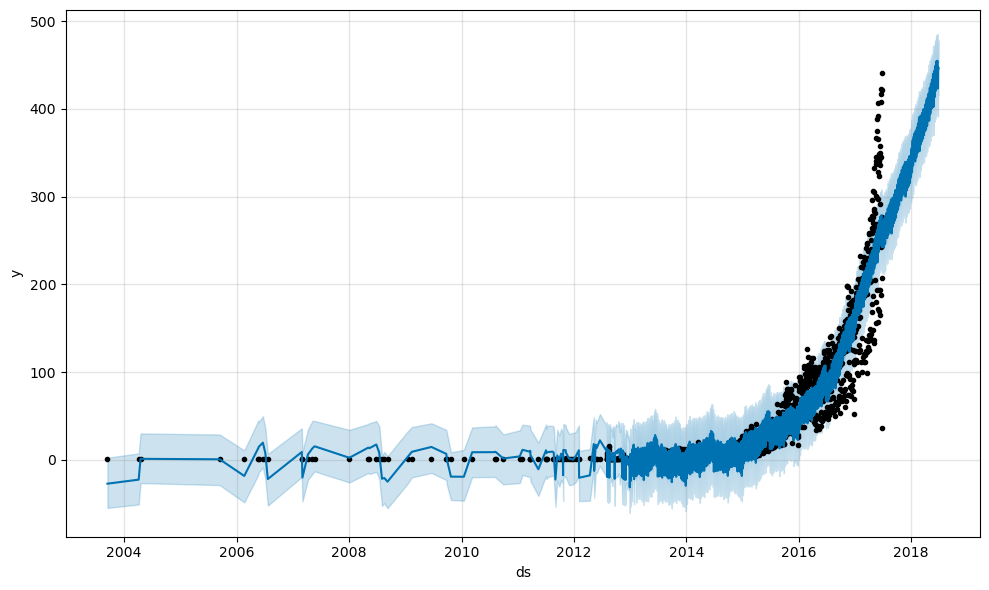

In [10]:
fig1 = m.plot(forecast)

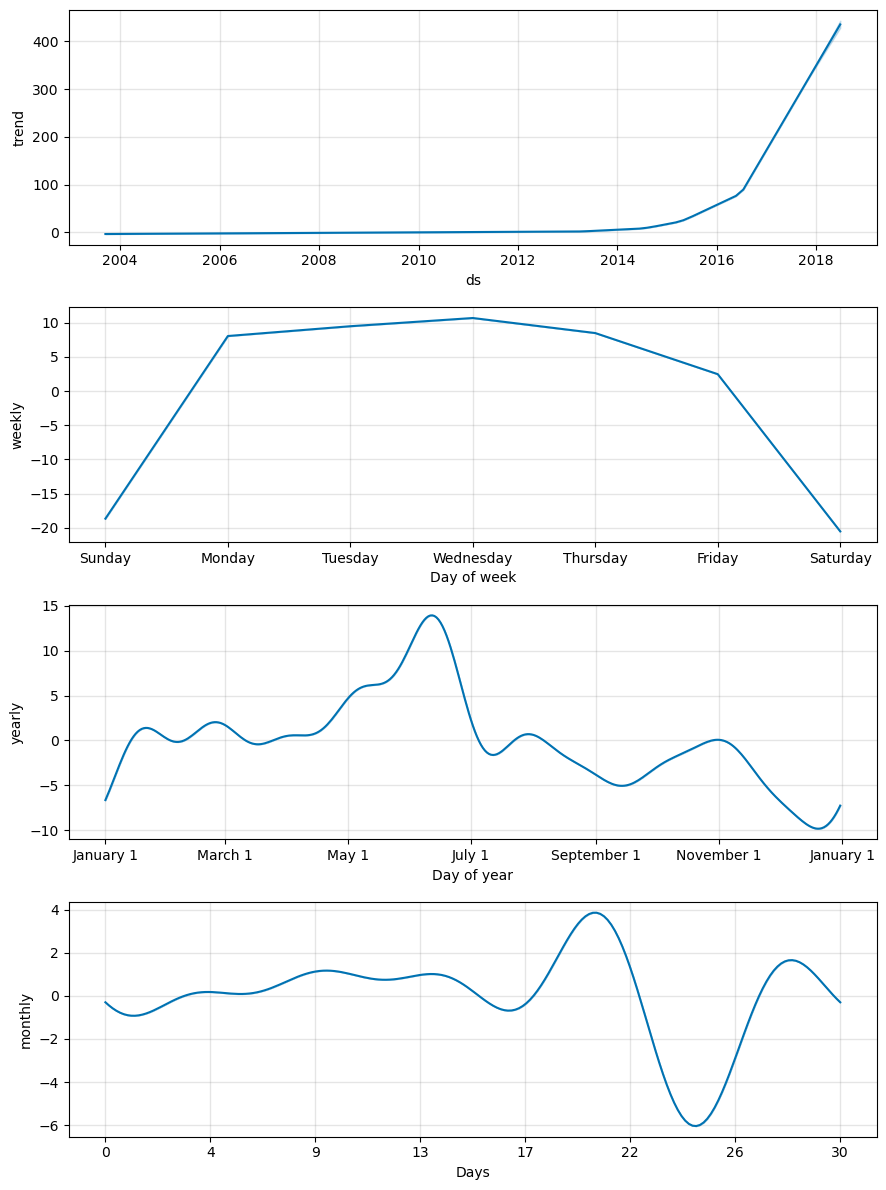

In [11]:
fig2 = m.plot_components(forecast)

In [12]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.FATAL)
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

  0%|          | 0/22 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2006-05-22,1.0,1.0,1.0,1,2006-02-20
1,2006-05-23,1.0,1.0,1.0,1,2006-02-20
2,2006-06-20,1.0,1.0,1.0,1,2006-02-20
3,2006-07-06,1.0,1.0,1.0,1,2006-02-20
4,2006-07-22,1.0,1.0,1.0,1,2006-02-20


In [13]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,40 days,143.006734,11.958542,7.362389,0.383427,0.287466,0.392685,0.479931
1,41 days,147.472924,12.143843,7.415119,0.377012,0.287011,0.389820,0.489426
2,42 days,150.722031,12.276890,7.415571,0.374533,0.282696,0.386709,0.493202
3,43 days,148.673926,12.193192,7.339371,0.369909,0.282696,0.381779,0.499784
4,44 days,145.346725,12.055983,7.263112,0.368614,0.283173,0.381946,0.503237


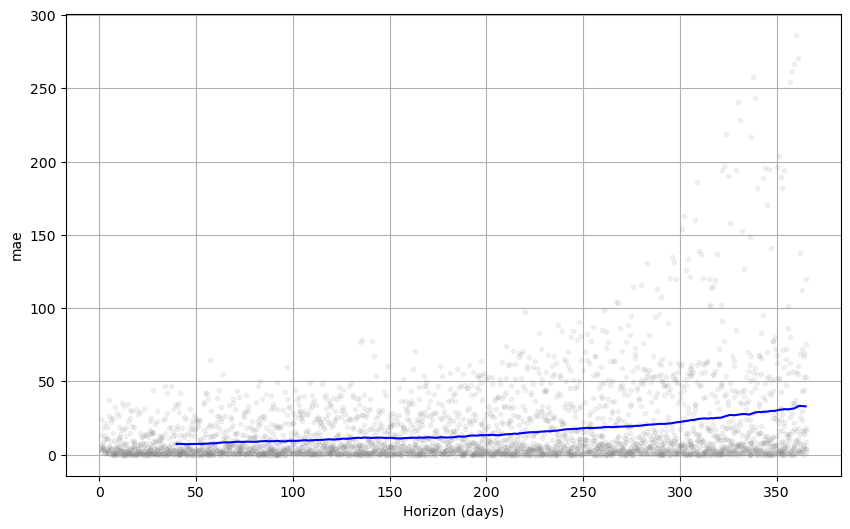

In [14]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [15]:
import itertools
import numpy as np
import pandas as pd

import logging
logging.getLogger('cmdstanpy').setLevel(logging.FATAL)

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='monthly', period=30.4, fourier_order=5)
    m.fit(df_by_day)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
print(tuning_results)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.01   
3                      0.001                     0.01                  0.01   
4                      0.001                     0.01                  0.10   
..                       ...                      ...                   ...   
251                    0.500                    10.00                  1.00   
252                    0.500                    10.00                 10.00   
253                    0.500                    10.00                 10.00   
254                    0.500                    10.00                 10.00   
255                    0.500                    10.00                 10.00   

    seasonality_mode  changepoint_range       rmse 

In [16]:
tuning_results.sort_values('mae').head(40)

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,rmse,mae
202,0.5,0.01,1.00,multiplicative,0.80,27.628353,13.275804
206,0.5,0.01,10.00,multiplicative,0.80,27.628353,13.275804
198,0.5,0.01,0.10,multiplicative,0.80,27.628353,13.275804
194,0.5,0.01,0.01,multiplicative,0.80,27.628353,13.275804
243,0.5,10.00,0.01,multiplicative,0.95,28.257923,13.821744
247,0.5,10.00,0.10,multiplicative,0.95,28.257923,13.821744
255,0.5,10.00,10.00,multiplicative,0.95,28.257923,13.821744
251,0.5,10.00,1.00,multiplicative,0.95,28.257923,13.821744
223,0.5,0.10,10.00,multiplicative,0.95,28.209471,13.900536
211,0.5,0.10,0.01,multiplicative,0.95,28.209471,13.900536


In [17]:
import itertools
import numpy as np
import pandas as pd

# With different cross validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale' : [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'changepoint_range' : [0.8, 0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='monthly', period=30.4, fourier_order=5)
    m.fit(df_by_day)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m, initial='3650 days', period='30 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
print(tuning_results)

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Fall

KeyboardInterrupt: 

In [ ]:
tuning_results.sort_values('mae')

## Second version of tuning - Optuna

In [18]:
import optuna

trials_number = 256

def objective(trial) -> float:
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 1.0)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 100.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 100.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    changepoint_range = trial.suggest_uniform('changepoint_range', 0.65, 0.95)

    m = Prophet(changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale,
               holidays_prior_scale=holidays_prior_scale, seasonality_mode=seasonality_mode,
               changepoint_range=changepoint_range)
    m.add_seasonality(name='monthly', period=30.4, fourier_order=5)
    m.fit(df_by_day)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

    score = df_p['mae'].values[0]
    print("  MAE: {}".format(df_p['mae'].values[0]))
    print("  RMSE: {}".format(df_p['rmse'].values[0]))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return score

study_name = 'medium-monthly-study'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="minimize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "changepoint_prior_scale": 0.05,
        "seasonality_prior_scale": 10.0,
        "holidays_prior_scale": 10.0,
        "seasonality_mode": "additive",
        "changepoint_range": 0.8
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

[I 2023-03-10 14:55:09,370] A new study created in RDB with name: medium-monthly-study
/tmp/ipykernel_29530/1002997509.py:35: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  study.enqueue_trial({
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/home/jsowa/anaconda3/envs/prophetenv/lib/python3.11/site-packages/optuna/study/study.py:856: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  self.add_trial(


  MAE: 16.77346634669839
  RMSE: 32.76924254710307
  Params for trial 0: 
    changepoint_prior_scale: 0.05
    seasonality_prior_scale: 10.0
    holidays_prior_scale: 10.0
    seasonality_mode: additive
    changepoint_range: 0.8


Optimization terminated abnormally. Falling back to Newton.


  MAE: 16.071393451293698
  RMSE: 30.628963550768464
  Params for trial 1: 
    changepoint_prior_scale: 0.061685685420077394
    seasonality_prior_scale: 0.22433443197427116
    holidays_prior_scale: 0.1281484903365369
    seasonality_mode: multiplicative
    changepoint_range: 0.8312334983156937
  MAE: 24.590560573502184
  RMSE: 41.82882631063836
  Params for trial 2: 
    changepoint_prior_scale: 0.003482050378144239
    seasonality_prior_scale: 3.004162517124268
    holidays_prior_scale: 0.16934970888163406
    seasonality_mode: multiplicative
    changepoint_range: 0.7436529644487048
  MAE: 16.361855291170592
  RMSE: 31.065638356491423
  Params for trial 3: 
    changepoint_prior_scale: 0.03696434797164789
    seasonality_prior_scale: 0.0635996604293226
    holidays_prior_scale: 0.07887172249043956
    seasonality_mode: multiplicative
    changepoint_range: 0.8360558777730684
  MAE: 16.746469357593707
  RMSE: 31.380877289035865
  Params for trial 4: 
    changepoint_prior_scale: 0

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


  MAE: 18.868439029775484
  RMSE: 35.619832313449706
  Params for trial 9: 
    changepoint_prior_scale: 0.01663939653504933
    seasonality_prior_scale: 0.8748134907861388
    holidays_prior_scale: 0.03942290690833667
    seasonality_mode: additive
    changepoint_range: 0.7823966067857792
  MAE: 13.528509625072745
  RMSE: 28.02241631082858
  Params for trial 10: 
    changepoint_prior_scale: 0.801676948804222
    seasonality_prior_scale: 35.03259837653533
    holidays_prior_scale: 11.185052050668075
    seasonality_mode: multiplicative
    changepoint_range: 0.9430811243997417
  MAE: 13.469527918075647
  RMSE: 27.91741667366623
  Params for trial 11: 
    changepoint_prior_scale: 0.9225067892137133
    seasonality_prior_scale: 42.380315151645064
    holidays_prior_scale: 12.098031446206187
    seasonality_mode: multiplicative
    changepoint_range: 0.9281819452077184
  MAE: 13.518315856110904
  RMSE: 27.966825618563398
  Params for trial 12: 
    changepoint_prior_scale: 0.9854993571

Optimization terminated abnormally. Falling back to Newton.


  MAE: 20.47225660746787
  RMSE: 38.043958481104184
  Params for trial 18: 
    changepoint_prior_scale: 0.01168025942703498
    seasonality_prior_scale: 2.1476434327516114
    holidays_prior_scale: 26.52093551904468
    seasonality_mode: additive
    changepoint_range: 0.9182024508318474
  MAE: 13.791768334875476
  RMSE: 28.171149928881213
  Params for trial 19: 
    changepoint_prior_scale: 0.5578027369044434
    seasonality_prior_scale: 8.51983231819681
    holidays_prior_scale: 4.953286516831953
    seasonality_mode: multiplicative
    changepoint_range: 0.8669433751728044
  MAE: 15.56545348905944
  RMSE: 30.027732656015925
  Params for trial 20: 
    changepoint_prior_scale: 0.10744659288600586
    seasonality_prior_scale: 0.9475442245340091
    holidays_prior_scale: 0.81196813731648
    seasonality_mode: multiplicative
    changepoint_range: 0.7519330956781842
  MAE: 13.96732281722837
  RMSE: 28.308641729285902
  Params for trial 21: 
    changepoint_prior_scale: 0.42515148550079

  MAE: 13.93122725344904
  RMSE: 28.33898392723416
  Params for trial 46: 
    changepoint_prior_scale: 0.45876813361137264
    seasonality_prior_scale: 40.62531129350847
    holidays_prior_scale: 1.0221351398992984
    seasonality_mode: multiplicative
    changepoint_range: 0.9348397121820076
  MAE: 15.810567471826422
  RMSE: 30.171111376025365
  Params for trial 47: 
    changepoint_prior_scale: 0.3271756216431799
    seasonality_prior_scale: 99.52644891717624
    holidays_prior_scale: 17.28744156632227
    seasonality_mode: multiplicative
    changepoint_range: 0.7108543654836663
  MAE: 17.89049802851375
  RMSE: 34.31677230885515
  Params for trial 48: 
    changepoint_prior_scale: 0.02628115820238269
    seasonality_prior_scale: 0.015426857795363364
    holidays_prior_scale: 0.4523351940536726
    seasonality_mode: additive
    changepoint_range: 0.9150677870812443


Optimization terminated abnormally. Falling back to Newton.


  MAE: 13.709834496646994
  RMSE: 28.088674384307293
  Params for trial 49: 
    changepoint_prior_scale: 0.7136116371943737
    seasonality_prior_scale: 23.63973502047288
    holidays_prior_scale: 4.270999712076303
    seasonality_mode: multiplicative
    changepoint_range: 0.8420310883294087
  MAE: 21.270402161722387
  RMSE: 36.90052758787148
  Params for trial 50: 
    changepoint_prior_scale: 0.0053783093696448585
    seasonality_prior_scale: 3.9513576176252143
    holidays_prior_scale: 0.16026190662659018
    seasonality_mode: multiplicative
    changepoint_range: 0.8680754967800219
  MAE: 13.583524617792168
  RMSE: 28.019039066644137
  Params for trial 51: 
    changepoint_prior_scale: 0.734581134455977
    seasonality_prior_scale: 5.64809851901933
    holidays_prior_scale: 0.26609398617475727
    seasonality_mode: multiplicative
    changepoint_range: 0.937600998478485
  MAE: 13.66957119140348
  RMSE: 28.078469458592167
  Params for trial 52: 
    changepoint_prior_scale: 0.7909

  MAE: 13.654683288824156
  RMSE: 28.09014197567008
  Params for trial 77: 
    changepoint_prior_scale: 0.8105156772028712
    seasonality_prior_scale: 48.53670313352263
    holidays_prior_scale: 18.40971897559869
    seasonality_mode: multiplicative
    changepoint_range: 0.9232675081624901
  MAE: 13.884710367896867
  RMSE: 28.161584659958137
  Params for trial 78: 
    changepoint_prior_scale: 0.6782700375205911
    seasonality_prior_scale: 0.45949278428145063
    holidays_prior_scale: 20.393730360997296
    seasonality_mode: multiplicative
    changepoint_range: 0.8991393798622933


Optimization terminated abnormally. Falling back to Newton.


  MAE: 20.332493764799178
  RMSE: 35.60724120554355
  Params for trial 79: 
    changepoint_prior_scale: 0.0068542797542759035
    seasonality_prior_scale: 19.743476964141617
    holidays_prior_scale: 32.40653708138066
    seasonality_mode: multiplicative
    changepoint_range: 0.9104919099622131
  MAE: 14.254746238040545
  RMSE: 28.593369120867457
  Params for trial 80: 
    changepoint_prior_scale: 0.4783492959536902
    seasonality_prior_scale: 32.53602312813684
    holidays_prior_scale: 8.242428058178229
    seasonality_mode: multiplicative
    changepoint_range: 0.7959250752279541
  MAE: 13.525869888847174
  RMSE: 28.018807837984845
  Params for trial 81: 
    changepoint_prior_scale: 0.8163705719671157
    seasonality_prior_scale: 61.78949491000963
    holidays_prior_scale: 5.087767513325157
    seasonality_mode: multiplicative
    changepoint_range: 0.8789456590414654
  MAE: 13.744927975208263
  RMSE: 28.14523008822965
  Params for trial 82: 
    changepoint_prior_scale: 0.97362

  MAE: 13.593728961601807
  RMSE: 29.51623040966466
  Params for trial 107: 
    changepoint_prior_scale: 0.7155844791831869
    seasonality_prior_scale: 0.014753475099420944
    holidays_prior_scale: 0.03062859249078142
    seasonality_mode: multiplicative
    changepoint_range: 0.9107064317188509
  MAE: 12.691190400692804
  RMSE: 27.171967059766086
  Params for trial 108: 
    changepoint_prior_scale: 0.5660777876912453
    seasonality_prior_scale: 0.02541515384446671
    holidays_prior_scale: 0.030674149652081213
    seasonality_mode: multiplicative
    changepoint_range: 0.9359655654567309
  MAE: 14.46286392914947
  RMSE: 29.104448110525254
  Params for trial 109: 
    changepoint_prior_scale: 0.09354226278622377
    seasonality_prior_scale: 0.025692360098897256
    holidays_prior_scale: 0.020163041946690784
    seasonality_mode: multiplicative
    changepoint_range: 0.9374537071287645
  MAE: 13.793557463292608
  RMSE: 29.700462959367435
  Params for trial 110: 
    changepoint_pri

  MAE: 12.68051619134331
  RMSE: 27.207905491463304
  Params for trial 135: 
    changepoint_prior_scale: 0.44985776750075523
    seasonality_prior_scale: 0.016898142826896945
    holidays_prior_scale: 0.014920191693772707
    seasonality_mode: multiplicative
    changepoint_range: 0.9206503986387333
  MAE: 12.82502699703644
  RMSE: 27.62438496913628
  Params for trial 136: 
    changepoint_prior_scale: 0.44934503127557623
    seasonality_prior_scale: 0.01655695567856655
    holidays_prior_scale: 0.014585025829179662
    seasonality_mode: multiplicative
    changepoint_range: 0.9217699409757841
  MAE: 13.55964896696666
  RMSE: 29.110735361983522
  Params for trial 137: 
    changepoint_prior_scale: 0.44377707528307386
    seasonality_prior_scale: 0.010577706756761614
    holidays_prior_scale: 0.013760462219265067
    seasonality_mode: multiplicative
    changepoint_range: 0.9288083120354587
  MAE: 12.672860514310758
  RMSE: 27.185016907235873
  Params for trial 138: 
    changepoint_pr

  MAE: 12.569810711034725
  RMSE: 27.11016815276652
  Params for trial 163: 
    changepoint_prior_scale: 0.4004724842916658
    seasonality_prior_scale: 0.015389990561899835
    holidays_prior_scale: 0.040757803510216864
    seasonality_mode: multiplicative
    changepoint_range: 0.9389505494044782
  MAE: 12.756110379426449
  RMSE: 27.319322101333015
  Params for trial 164: 
    changepoint_prior_scale: 0.4069440658938772
    seasonality_prior_scale: 0.015153197977927463
    holidays_prior_scale: 0.040759232162097744
    seasonality_mode: multiplicative
    changepoint_range: 0.9410842253515123
  MAE: 13.543434126856168
  RMSE: 29.443467703840597
  Params for trial 165: 
    changepoint_prior_scale: 0.49273044695506624
    seasonality_prior_scale: 0.013326487708910767
    holidays_prior_scale: 0.025333194146635506
    seasonality_mode: multiplicative
    changepoint_range: 0.9281123354886873
  MAE: 13.205868041746873
  RMSE: 28.59448173716136
  Params for trial 166: 
    changepoint_p

  MAE: 12.735122840307648
  RMSE: 27.340476546397284
  Params for trial 191: 
    changepoint_prior_scale: 0.3060870184476475
    seasonality_prior_scale: 0.014674707973241293
    holidays_prior_scale: 0.034458318150597536
    seasonality_mode: multiplicative
    changepoint_range: 0.9416042545899739
  MAE: 12.672944142544173
  RMSE: 27.207014808621224
  Params for trial 192: 
    changepoint_prior_scale: 0.35249925928208503
    seasonality_prior_scale: 0.016523268030899693
    holidays_prior_scale: 0.02584976807389792
    seasonality_mode: multiplicative
    changepoint_range: 0.9368273600848581
  MAE: 12.65964649726893
  RMSE: 27.15239244880393
  Params for trial 193: 
    changepoint_prior_scale: 0.4223556400674674
    seasonality_prior_scale: 0.018377195862387573
    holidays_prior_scale: 0.02566713391564807
    seasonality_mode: multiplicative
    changepoint_range: 0.935919133792042
  MAE: 12.759805513791378
  RMSE: 27.402805911974596
  Params for trial 194: 
    changepoint_prio

  MAE: 12.668919152471137
  RMSE: 27.16432451361158
  Params for trial 219: 
    changepoint_prior_scale: 0.4023882723143694
    seasonality_prior_scale: 0.0204253721068746
    holidays_prior_scale: 0.039909118850394054
    seasonality_mode: multiplicative
    changepoint_range: 0.9199508805808707
  MAE: 12.673741802918569
  RMSE: 27.299228055656485
  Params for trial 220: 
    changepoint_prior_scale: 0.38055411327305055
    seasonality_prior_scale: 0.021055726928987654
    holidays_prior_scale: 0.04116335532234128
    seasonality_mode: multiplicative
    changepoint_range: 0.9158621634220296
  MAE: 14.438073884534147
  RMSE: 28.58711321902151
  Params for trial 221: 
    changepoint_prior_scale: 0.37937652649959125
    seasonality_prior_scale: 1.2588104164764966
    holidays_prior_scale: 0.04123335414935838
    seasonality_mode: multiplicative
    changepoint_range: 0.9207601915741336
  MAE: 12.740816294100187
  RMSE: 27.348122962808326
  Params for trial 222: 
    changepoint_prior_

  MAE: 12.78128376312346
  RMSE: 27.291507636181045
  Params for trial 247: 
    changepoint_prior_scale: 0.45858913873386703
    seasonality_prior_scale: 0.023415418978232093
    holidays_prior_scale: 0.028933621977013504
    seasonality_mode: multiplicative
    changepoint_range: 0.9410638776340046
  MAE: 12.804118325479536
  RMSE: 27.514519844388783
  Params for trial 248: 
    changepoint_prior_scale: 0.5318899138479574
    seasonality_prior_scale: 0.018355089968696132
    holidays_prior_scale: 0.022832450431092426
    seasonality_mode: multiplicative
    changepoint_range: 0.9321587500339609
  MAE: 14.278404836197211
  RMSE: 28.47531066387428
  Params for trial 249: 
    changepoint_prior_scale: 0.42648489309366655
    seasonality_prior_scale: 0.2927294267809754
    holidays_prior_scale: 0.037032051260730586
    seasonality_mode: multiplicative
    changepoint_range: 0.9452172126163927
  MAE: 13.002806888638204
  RMSE: 27.626373549089998
  Params for trial 250: 
    changepoint_pr

In [19]:
print("\nBest trial:")
trial = study.best_trial

print("  MAE: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  MAE: 12.567369378959985
  Params: 
    changepoint_prior_scale: 0.38304447372778944
    changepoint_range: 0.939396328911343
    holidays_prior_scale: 0.03139986877520668
    seasonality_mode: multiplicative
    seasonality_prior_scale: 0.015462543669993074


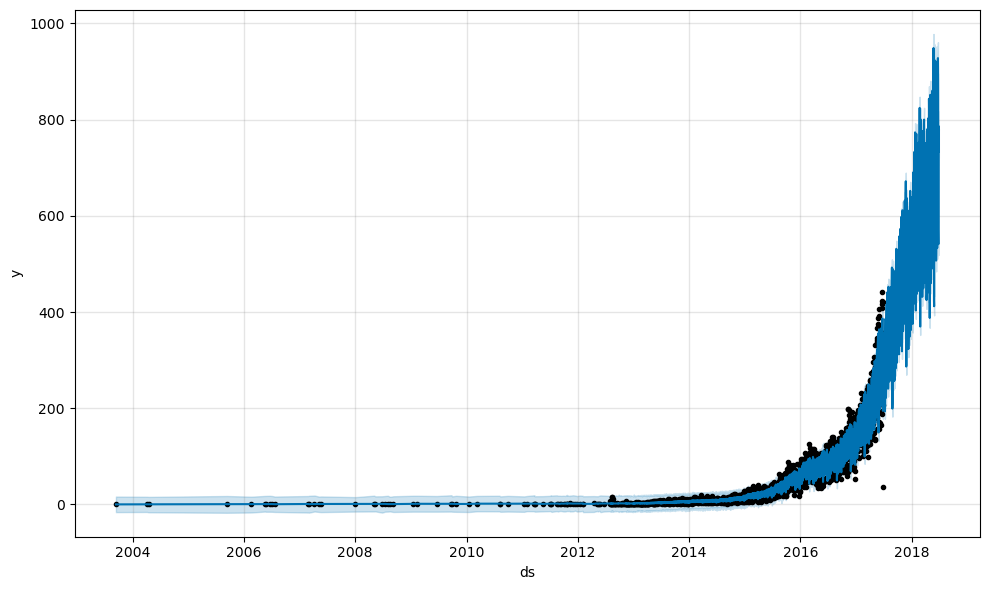

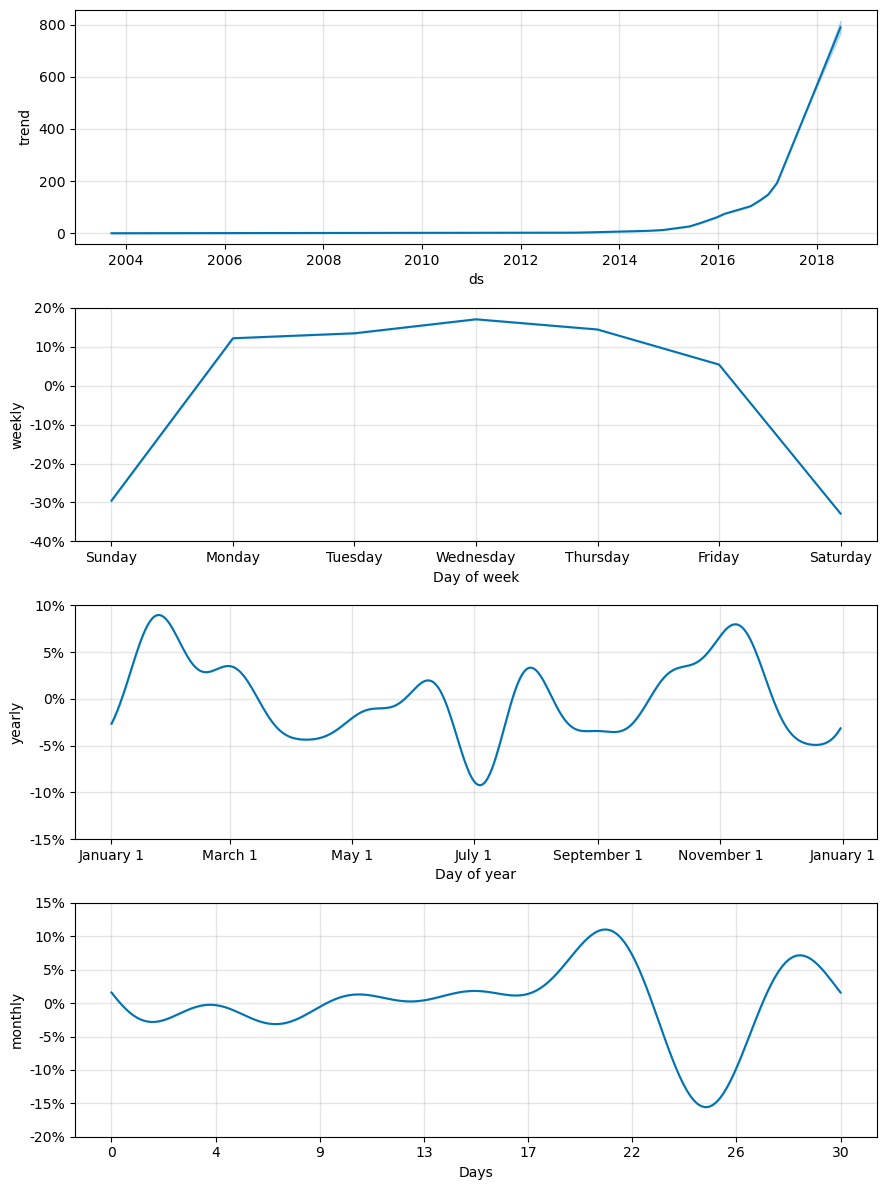

In [20]:
m = Prophet(changepoint_prior_scale=0.38304447372778944, seasonality_prior_scale=0.015462543669993074,
               holidays_prior_scale=0.03139986877520668, seasonality_mode="multiplicative",
               changepoint_range=0.939396328911343)
m.add_seasonality(name='monthly', period=30.4, fourier_order=5)
m.fit(df_by_day)  # Fit model with given params

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)